# Reconstruction with real data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate_z0
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio, ab_initio_mcmc
import jax

import mrcfile

plt.rcParams["figure.figsize"]=6,6

### Read the data

In [3]:
#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = "job550_particles_subsamp5_10000_30_40_2.star"
#star_file = "job550_particles_roy40k.star"
#star_file = "job550_particles.star"


#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/Frost/eIF2B/job042/"
#star_file = "AUG11_99Kparticles_updatedGCTF.star"

#data_dir = "/project/lederman/rrl28/share/CryoEMDataSmall/RelionSample/relion30_tutorial_precalculated_results/"
#star_file = "Extract/job020/particles.star"

#data_dir = "/gpfs/gibbs/pi/lederman/dge5/RELION_TUTORIAL_SET/PrecalculatedResults/"
#star_file = "/Extract/job018/particles.star"

data_dir = "/gpfs/gibbs/pi/lederman/3DFSC_data/tilted/Particle-Stack/"
star_file = "T40_HA_130K-Equalized_run-data.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)
ctf_params0 = params0["ctf_params"]
pixel_size0 = params0["pixel_size"]
angles0 = params0["angles"]
shifts0 = params0["shifts"]


/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles:  130000
load_data: data loaded, time:  64.47866916656494


In [4]:
print(imgs0.shape)
print(pixel_size0.shape)
print(angles0.shape)
print(shifts0.shape)
print(ctf_params0.shape)

#plt.imshow(np.abs(jnp.fft.fftshift(imgs_f0[101]))); plt.colorbar()

(130000, 256, 256)
(130000,)
(130000, 3)
(130000, 2)
(130000, 9)


### Only keep N points at random (to avoid out of memory error)

In [5]:
N = 5000 # imgs0.shape[0]
idxrand = np.random.permutation(130000)[:N]

imgs0 = imgs0[idxrand]
pixel_size = pixel_size0[idxrand]
angles = angles0[idxrand]
shifts = shifts0[idxrand]
ctf_params = ctf_params0[idxrand]

### Some angle filtering

In [6]:
#idx = jnp.abs(angles0[:,2]) < jnp.pi/4
#imgs_f = imgs_f0[idx]
#pixel_size = pixel_size0[idx]
#angles = angles0[idx]
#shifts = shifts0[idx]
#ctf_params = ctf_params0[idx]

#idx2 = jnp.abs(angles[:,1]) < jnp.pi/3
#imgs_f = imgs_f[idx2]
#pixel_size = pixel_size[idx2]
#angles = angles[idx2]
#shifts = shifts[idx2]
#ctf_params = ctf_params[idx2]

#plot_angles(angles)

### Take the FFT of the images

In [7]:
imgs_f = np.array([np.fft.fft2(np.fft.ifftshift(img)) for img in imgs0])

### Create the grids

In [8]:
# Assume the pixel size is the same for all images
nx = imgs_f.shape[-1]
px = pixel_size[0]
N = imgs_f.shape[0]

x_grid = create_grid(nx, px)
y_grid = x_grid
z_grid = x_grid
print(x_grid)

[2.981875e-03 2.560000e+02]


### Crop images to 32 x 32 

In [9]:
nx = 32
imgs_f, x_grid = crop_fourier_images(imgs_f, x_grid, nx)

y_grid = x_grid
z_grid = x_grid
print(x_grid)

[2.981875e-03 6.400000e+01]


### Before further processing, vectorize the images, create mask etc

In [10]:
imgs_f = imgs_f.reshape(N, -1)
print(imgs_f.shape)

(20000, 4096)


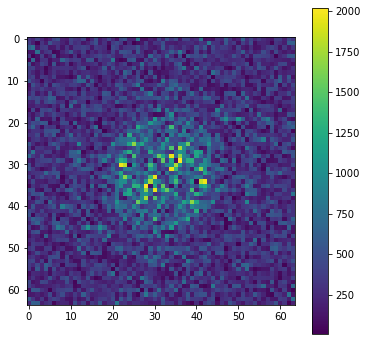

In [11]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[101].reshape(nx,nx)))); plt.colorbar()

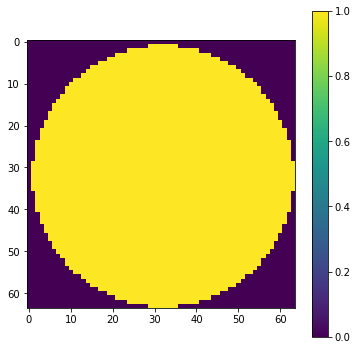

In [28]:
centre = (0,0,0)
#radius = 0.045 # for nx=32
radius = 0.093 # nx-64
#radius = 0.07 # for nx=64
#radius = 0.14 # for nx=128
#radius = 0.28 # for nx=256

mask = create_3d_mask(x_grid, centre, radius)

mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

### Estimate the noise

First, decide on the dimensions of the empty corners to use for noise estimation:

In [29]:
N_noise = 64
plt.imshow(jnp.mean(imgs0[:,:N_noise,:N_noise], axis=0))

NameError: name 'imgs0' is not defined

Only use a small subset of the data for noise estimation so the kernel doesn't crash (possibly due to running out of memory)

Text(0.5, 1.0, 'Estimated noise')

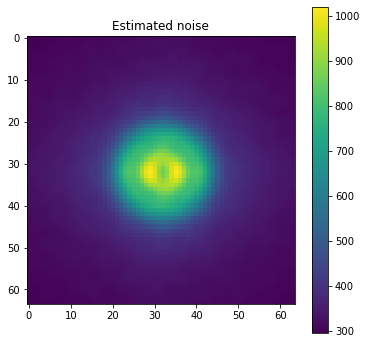

In [14]:
sigma_noise_estimated = estimate_noise_imgs(imgs0[:5000], nx_empty = N_noise, nx_final = nx).reshape([nx,nx])
plt.imshow(jnp.fft.fftshift(sigma_noise_estimated)); plt.colorbar()
plt.title('Estimated noise')

#### A quadratic noise model, fitted on the estimated one, for fun

Text(0.5, 1.0, 'Quadratic noise approximation')

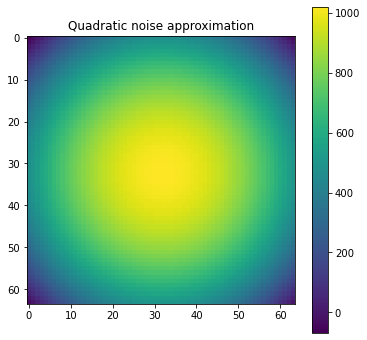

In [30]:
x_freq = jnp.fft.fftfreq(x_grid[1].astype(np.int64), 1/(x_grid[1] * x_grid[0]))
X,Y = jnp.meshgrid(x_freq, x_freq)
C = (jnp.max(sigma_noise_estimated)-jnp.min(sigma_noise_estimated))*1.5/jnp.max(X**2+Y**2)
sigma_noise_quadratic = jnp.max(sigma_noise_estimated) -(X**2 + Y**2)* C 
plt.imshow(jnp.fft.fftshift(sigma_noise_quadratic)); plt.colorbar()
plt.title('Quadratic noise approximation')

#### Average radially

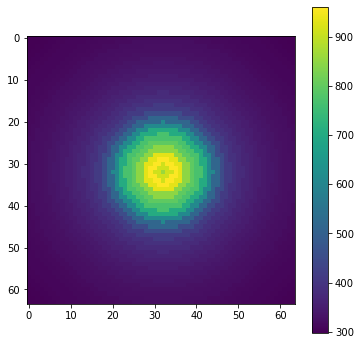

In [31]:
sigma_noise_avg = average_radially(sigma_noise_estimated, x_grid)

plt.imshow(jnp.fft.fftshift(sigma_noise_avg)); plt.colorbar()

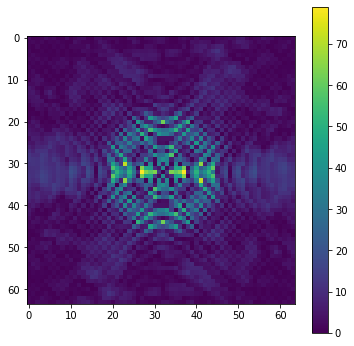

In [32]:
plt.imshow(jnp.fft.fftshift(jnp.abs(sigma_noise_avg-sigma_noise_estimated))); plt.colorbar()

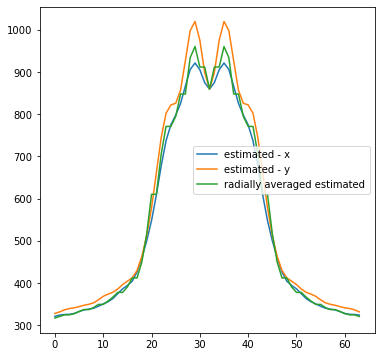

In [33]:
plt.plot(jnp.fft.fftshift(sigma_noise_estimated[:,0]))
plt.plot(jnp.fft.fftshift(sigma_noise_estimated[0,:]))
#plt.plot(jnp.fft.fftshift(sigma_noise_quadratic[:,0]))
plt.plot(jnp.fft.fftshift(sigma_noise_avg[:,0]))
#plt.legend(['estimated - x', 'estimated - y', 'quadratic', 'radially averaged estimated'])
plt.legend(['estimated - x', 'estimated - y', 'radially averaged estimated'])

In [34]:
sigma_noise = sigma_noise_avg.reshape(-1)

### Delete the real images
Since we only work with the Fourier ones from now on.

In [35]:
del(imgs0)
#del(imgs)

NameError: name 'imgs0' is not defined

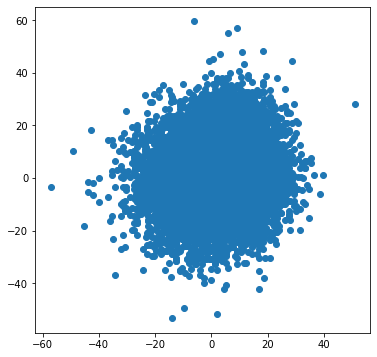

In [21]:
plt.scatter(shifts[:,0], shifts[:,1])

### Compare grad functions

In [36]:
v0 = jnp.array(np.random.randn(32,32,32))*100
n = 20000

In [37]:
t0 = time.time()
gb = grad_loss_volume_batched(v0, angles[:n], shifts[:n], ctf_params[:n], imgs_f[:n], sigma_noise)
print(time.time() - t0)

NameError: name 'grad_loss_volume_batched' is not defined

In [200]:
t0 = time.time()
gs = grad_loss_volume_sum(v0, angles[:n], shifts[:n], ctf_params[:n], imgs_f[:n], sigma_noise)
print(time.time() - t0)

0.06902909278869629


In [134]:
ls_lam(v0)

DeviceArray(680.06922774, dtype=float64)

In [103]:
loss_func_sum

<CompiledFunction of <function get_loss_funcs.<locals>.loss_func_sum at 0x2ab72b201f30>>

### Ab initio

In [22]:
type(imgs_f)

numpy.ndarray

In [23]:
#old_stdout = sys.stdout
#sys.stdout = open('../data/relion/output.txt', 'w')

In [24]:
#sys.stdout = sys.__stdout__

In [25]:
#v_rec_int = v_rec
#angles_rec_int = angles_rec

Fourier radius: 0.09542
Starting radius: 0.01
Frequency marching step size: 0.005164759001819446
Number of frequency marching steps: 17
------------------------------------

Initialitsing volume
  sgd epoch 0: mean gradient = 2.4815792118427195e-08
  sgd epoch 10: mean gradient = 1.0118676142788771e-08


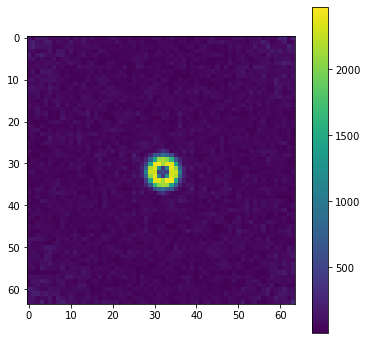

Iter  0
  MC sample 20 , loss = 17.170479687933856
  Time orientations sampling = 7.326014757156372
  mean(a_angles) = 0.7541020398719595
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 17.470234038548504
  Time volume sampling = 14.083784103393555
  mean(a_vol) = 1.0
2022-03-03 18:29:41.180698
  nx = 8


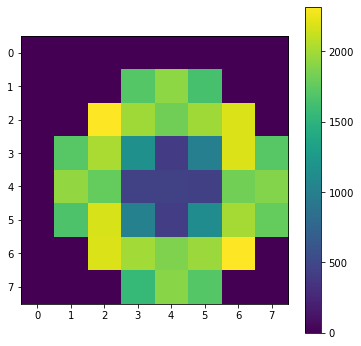

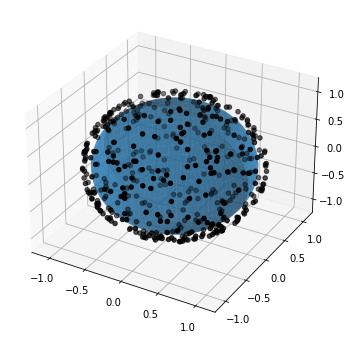

Iter  1
  MC sample 20 , loss = 42.819756331248016
  Time orientations sampling = 4.771826267242432
  mean(a_angles) = 0.857922363902159
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 42.19476225460392
  Time volume sampling = 23.919771194458008
  mean(a_vol) = 1.0
Iter  2
  MC sample 20 , loss = 41.67003887251319
  Time orientations sampling = 4.740247488021851
  mean(a_angles) = 0.8476869505005997
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 42.04821501351118
  Time volume sampling = 22.602529764175415
  mean(a_vol) = 0.9999999769838127
Iter  3
  MC sample 20 , loss = 41.62914529128349
  Time orientations sampling = 4.687374591827393
  mean(a_angles) = 0.8262917503166061
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 42.02256604949234
  Time volume sampling = 21.70740580558777
  mean(a_vol) = 1.0
Iter  4
  MC sample 20 , loss = 41.58528987393688
  Time orientations sampling = 4.7579615116119385
  mean(a_angles) = 0.7953386379941727
  Iter 20 , a =  1.0
  MC 

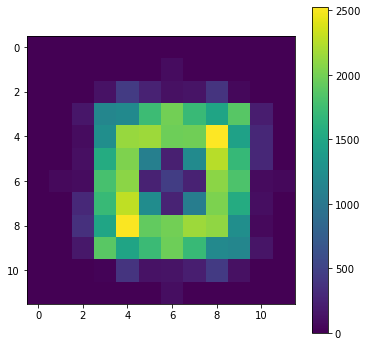

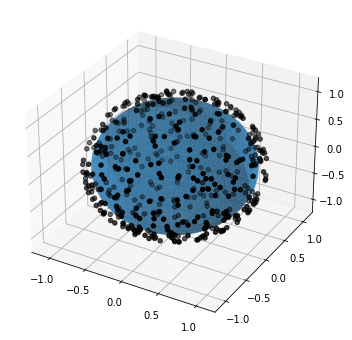

Iter  9
  MC sample 20 , loss = 69.36802331600444
  Time orientations sampling = 6.198518753051758
  mean(a_angles) = 0.5591371161073703
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 69.72889407091577
  Time volume sampling = 31.395979404449463
  mean(a_vol) = 0.9999977294690849
Iter  10
  MC sample 20 , loss = 69.11611488593161
  Time orientations sampling = 6.193928003311157
  mean(a_angles) = 0.4991883192373408
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 69.5084798814022
  Time volume sampling = 27.633142948150635
  mean(a_vol) = 0.999992132929981
Iter  11
  MC sample 20 , loss = 68.83892818851946
  Time orientations sampling = 6.0973615646362305
  mean(a_angles) = 0.4329448103051329
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 69.24143456517393
  Time volume sampling = 27.899049282073975
  mean(a_vol) = 0.9999711928983935
Iter  12
  MC sample 20 , loss = 68.57490093877418
  Time orientations sampling = 6.18809175491333
  mean(a_angles) = 0.376879507306

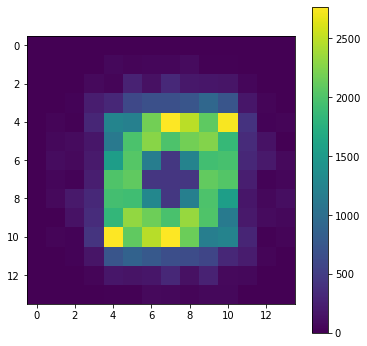

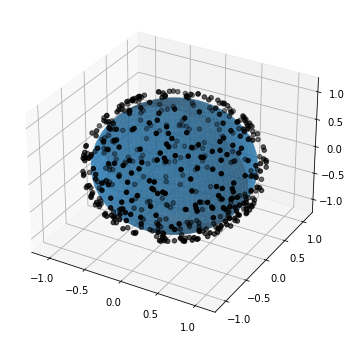

Iter  17
  MC sample 20 , loss = 116.92764253546447
  Time orientations sampling = 9.015251874923706
  mean(a_angles) = 0.29024404007068094
  Iter 20 , a =  3.5259352775229966e-280
  MC sample 20 , loss (of mean) = 117.15833092413531
  Time volume sampling = 38.523465633392334
  mean(a_vol) = 0.6000000000000001
Iter  18
  MC sample 20 , loss = 116.35682544506975
  Time orientations sampling = 8.009170055389404
  mean(a_angles) = 0.2456230680239524
  Iter 20 , a =  7.508025505867722e-187
  MC sample 20 , loss (of mean) = 116.76392288733241
  Time volume sampling = 39.52517056465149
  mean(a_vol) = 0.84999749528725
Iter  19
  MC sample 20 , loss = 115.98796955110788
  Time orientations sampling = 8.016735076904297
  mean(a_angles) = 0.21134813127686533
  Iter 20 , a =  5.705566799665888e-62
  MC sample 20 , loss (of mean) = 116.4249626273342
  Time volume sampling = 40.17193126678467
  mean(a_vol) = 0.8999998826408628
Iter  20
  MC sample 20 , loss = 115.62518003730784
  Time orientation

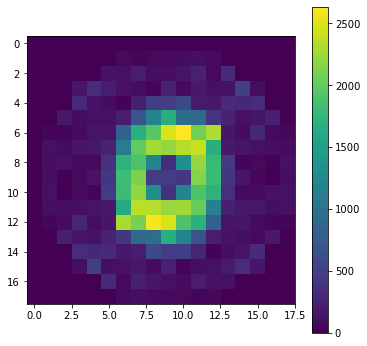

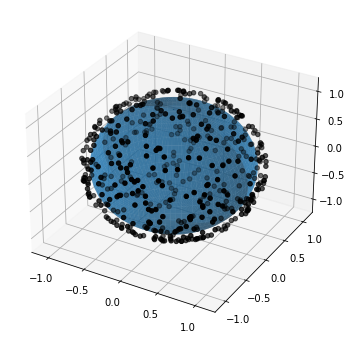

Iter  25
  MC sample 20 , loss = 169.67569518852844
  Time orientations sampling = 9.797821283340454
  mean(a_angles) = 0.11360635231804617
  Iter 20 , a =  0.9998860727643156
  MC sample 20 , loss (of mean) = 169.65632010692002
  Time volume sampling = 58.10576677322388
  mean(a_vol) = 0.7999943036382158
Iter  26
  MC sample 20 , loss = 168.6413543136083
  Time orientations sampling = 9.727476596832275
  mean(a_angles) = 0.09048008871613972
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 169.09605416137194
  Time volume sampling = 53.91045880317688
  mean(a_vol) = 0.7999975292198923
Iter  27
  MC sample 20 , loss = 168.24678848400933
  Time orientations sampling = 9.705276727676392
  mean(a_angles) = 0.07372044236506207
  Iter 20 , a =  2.15709266400998e-105
  MC sample 20 , loss (of mean) = 168.7601329598236
  Time volume sampling = 53.461344718933105
  mean(a_vol) = 0.7999950590542513
Iter  28
  MC sample 20 , loss = 167.97433529289742
  Time orientations sampling = 9.7609965

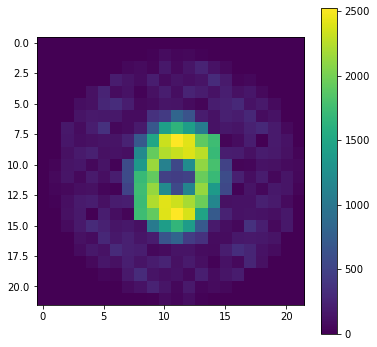

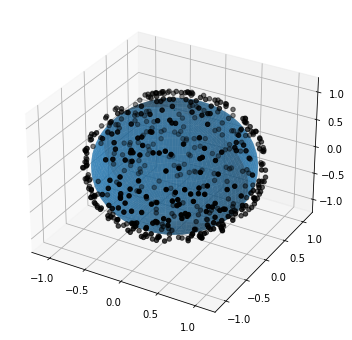

Iter  33
  MC sample 20 , loss = 220.07118721681275
  Time orientations sampling = 11.915902137756348
  mean(a_angles) = 0.04705997249501664
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 220.41938557379805
  Time volume sampling = 82.56498837471008
  mean(a_vol) = 0.9999863892154025
Iter  34
  MC sample 20 , loss = 219.62936653126897
  Time orientations sampling = 11.581923961639404
  mean(a_angles) = 0.041681333860758264
  Iter 20 , a =  0.0
  MC sample 20 , loss (of mean) = 220.18221663770757
  Time volume sampling = 72.20994806289673
  mean(a_vol) = 0.749830085353334
Iter  35
  MC sample 20 , loss = 219.42975629543253
  Time orientations sampling = 11.469645261764526
  mean(a_angles) = 0.03751278397611793
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 219.99717527429306
  Time volume sampling = 74.93754577636719
  mean(a_vol) = 0.8499929380333408
Iter  36
  MC sample 20 , loss = 219.27492802668996
  Time orientations sampling = 11.8266761302948
  mean(a_angles) = 0.

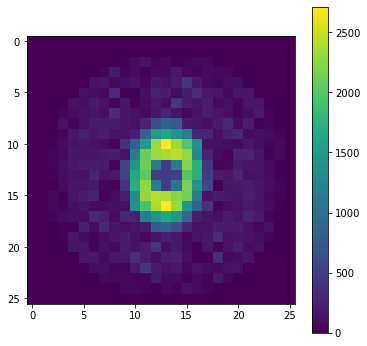

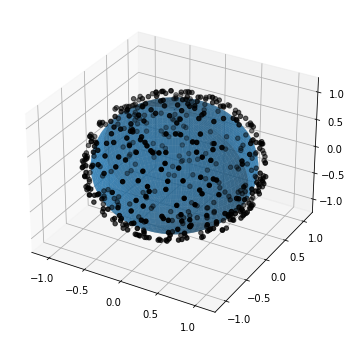

Iter  41
  MC sample 20 , loss = 291.41997234140064
  Time orientations sampling = 13.144250869750977
  mean(a_angles) = 0.026800666214857032


In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))


# The number of iterations desn't matter, 
# since it stops when the volume is nx x nx x nx.
N_samples = 40000
N_iter = 1000000


radius0 = 0.01
#radius0 = 0.03
alpha = 1e-9  # <--- this is the working one
#alpha = 1e-6

# The number of cg or sgd iterations also doesn't matter,
# since it stops when it reaches the desired accuracy.
N_cg_iter = 100000
eps_cg = 3e-5

N_sgd_iter = 100000
batch_size = 300
learning_rate = 1e6
#learning_rate = 1
eps_gd = 1e-8 
eps_gd = 2e-8
P = None

use_sgd = True

if use_sgd:
    N_vol_iter = N_sgd_iter
    eps_vol = eps_gd
else:
    N_vol_iter = N_cg_iter
    eps_vol = eps_cg

N_samples_angles = 21 #100
N_samples_vol = 21    

# HMC params
#dt = 5
dt_list = jnp.array([0.1, 0.5, 1, 5, 10])
L = 10

vol0 = None
angles0 = None
#sigma_noise = jnp.ones(sigma_noise.shape)
    
out_dir = '../data/3dfsc/'
imgs_f = imgs_f.reshape([N, nx*nx])

opt_vol_first = True

#v_rec, angles_rec = ab_initio(project, imgs_f, sigma_noise, shifts, ctf_params, x_grid, use_sgd, N_iter, N_vol_iter, learning_rate, batch_size, P, N_samples, radius0, None, alpha, eps_vol, 'tri', True, True, True, out_dir)
v_rec, angles_rec, angles_samples, angles_r, v_samples, v_r = ab_initio_mcmc(key, project, imgs_f, sigma_noise, shifts, ctf_params, x_grid, use_sgd, vol0, angles0, N_iter, learning_rate, batch_size, P, N_samples_angles, N_samples_vol, dt_list, L, radius0, None, alpha, eps_vol, 'tri', opt_vol_first, True, True, out_dir)



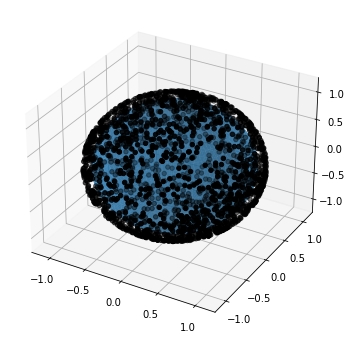

In [104]:
plot_angles(angles_rec[:2000])

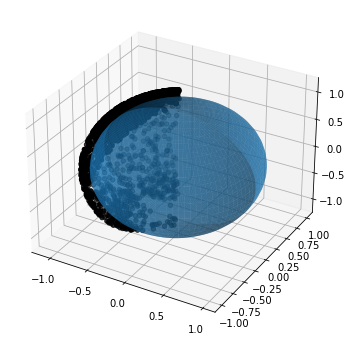

In [28]:
plot_angles(angles[:2000])

In [237]:
angles_r.shape

(999, 10000)

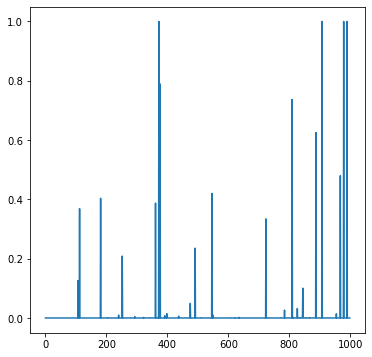

In [420]:
plt.plot(angles_r[:,100])

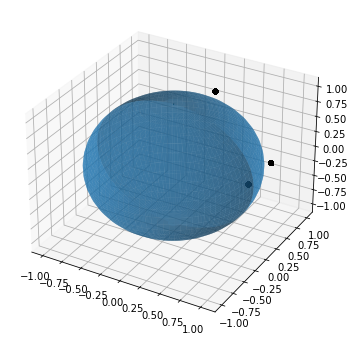

In [421]:
ae = angles_samples[:,3993,:]
ae.shape
plot_angles(ae)

In [67]:
angles_samples.shape

(999, 10000, 3)

In [225]:
angles_samples[:,3993,:]

DeviceArray([[1.3157887 , 2.47968212, 0.91884977],
             [1.3157887 , 2.47968212, 0.91884977],
             [1.3157887 , 2.47968212, 0.91884977],
             ...,
             [0.13064206, 0.97276588, 5.47910001],
             [0.13064206, 0.97276588, 5.47910001],
             [0.13064206, 0.97276588, 5.47910001]], dtype=float64)

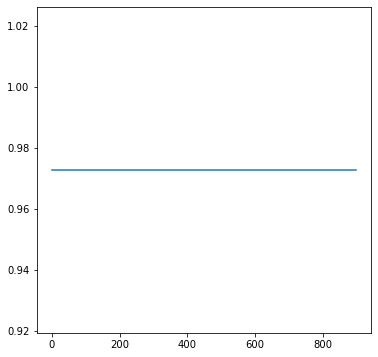

In [229]:
plt.plot(ae[100:,1])

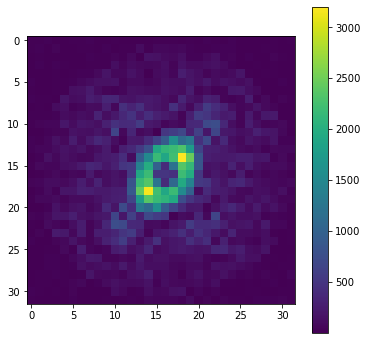

In [244]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_samples[0,:,:,0]))); plt.colorbar()

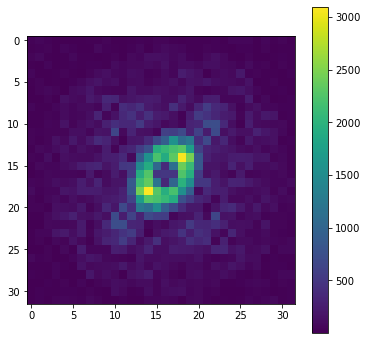

In [245]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_samples[20,:,:,0]))); plt.colorbar()

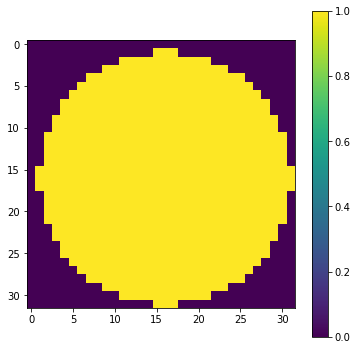

In [255]:
plt.imshow(jnp.abs(jnp.fft.fftshift(mask[:,:,0]))); plt.colorbar()

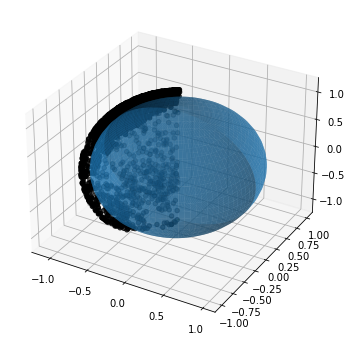

In [53]:
plot_angles(angles0[idxrand])

### MCMC vol

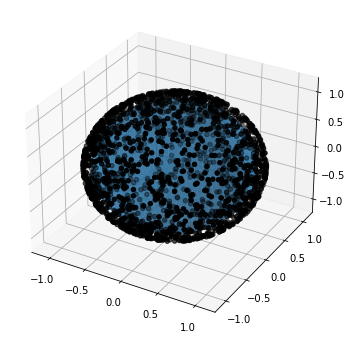

In [296]:
plot_angles(angles_rec[:2000])

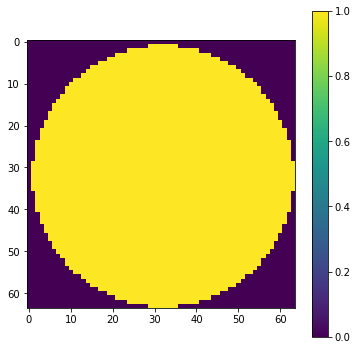

In [105]:
alpha = 1e-9
#alpha = 1e-6

#radius = 0.045 # for nx=32
radius = 0.093
#radius = 1.6 # for nx=64
#radius = 3.2 # for nx=128)
mask = create_3d_mask(x_grid, (0,0,0),radius)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()
M = 1/jnp.max(sigma_noise)**2 * jnp.ones([nx, nx, nx])

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")

loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)


logPi = lambda v : -loss_func_sum(v, angles_rec, shifts, ctf_params, imgs_f, sigma_noise)
gradLogPi = lambda v : -jnp.conj(grad_loss_volume_sum(v, angles_rec, shifts, ctf_params, imgs_f, sigma_noise))
#gradLogPi = lambda v : gradLogPi_split(v, angles_rec, shifts, ctf_params, imgs_f, sigma_noise, 10)


In [107]:
N_mc_samples = 21
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

#v0 = (jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx)) )
v0 = jnp.zeros([nx,nx,nx])*1j
#v0 = v_rec
proposal_params_mala = {"tau" : 0.005}

dt_list = jnp.array([0.1, 0.5, 5, 10])
#dt_list = jnp.array([5])
proposal_params_hmc = {"dt_list" : dt_list, "L" : 10, "M" : M, "gradLogPi" : gradLogPi}

v_hmc_mean, r_hmc, v_hmc_samples = mcmc(key, N_mc_samples, proposal_hmc, logPi, v0, proposal_params_hmc)

  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 2004.2185861415217


0.8500000000000001


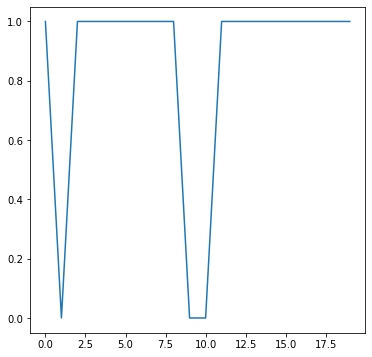

In [108]:
print(jnp.mean(r_hmc))
plt.plot(r_hmc)

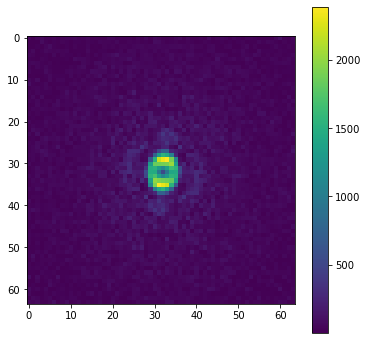

In [109]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_hmc_samples[N_mc_samples-2,:,:,0]))); plt.colorbar()

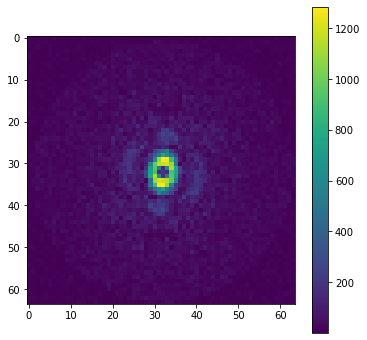

In [110]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_hmc_mean[:,:,0]))); plt.colorbar()

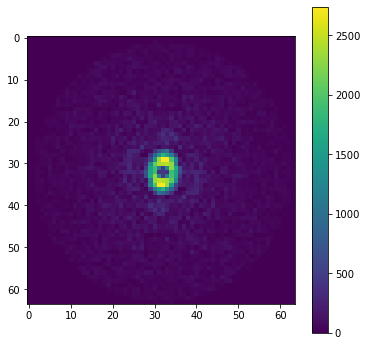

In [111]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_rec[:,:,0]))); plt.colorbar()

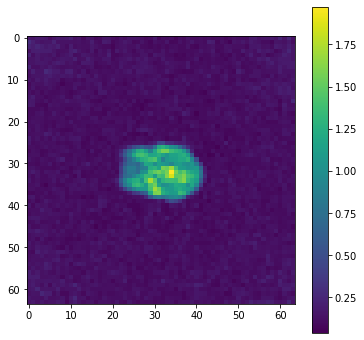

In [112]:
v_hmc_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_hmc_mean)))
mip_z(v_hmc_r)
plt.colorbar()

In [113]:
with mrcfile.new('../data/reconstruction_data_v_hmc_mean_list_10_1e-9_ar.mrc', overwrite=True) as mrc:
    mrc.set_data(v_hmc_r.astype(np.float32))

In [121]:
file = open('../data/3dfsc64/angles_rec', 'w')
file.write(angles_rec)
file.close()

TypeError: write() argument must be str, not DeviceArray

In [124]:

import pickle
file = open('../data/3dfsc64/angles_rec', 'wb')
pickle.dump(angles_rec, file)
file.close()

In [125]:
with open('../data/3dfsc64/angles_rec', 'rb') as file:
      
    # Call load method to deserialze
    angles_rec2 = pickle.load(file)

In [129]:
jnp.sum(jnp.abs(angles_rec2 - angles_rec))

DeviceArray(0., dtype=float64)

### MCMC orientations

In [23]:
alpha0 = 0

radius = 0.4
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func0, loss_func_batched0, loss_func_sum0, _ = get_loss_funcs(slice_func, alpha = alpha0)
logPi_batch = lambda a : -loss_func_batched0(vol_fourier, a, shifts_true, ctf_params, imgs, 1)

### CG - choosing $\alpha$

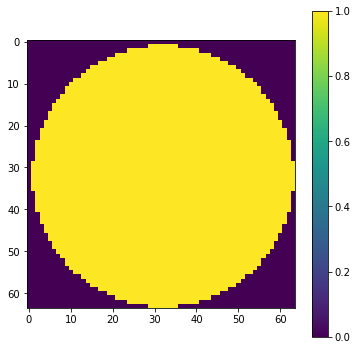

In [63]:
centre = (0,0,0)
#radius = 0.045
radius = 0.093
mask = create_3d_mask(x_grid, centre, radius)
mask2d = mask[:,:,0]

plt.imshow(jnp.fft.fftshift(mask2d)); plt.colorbar()

First, the slice function and the data fidelity function (i.e. the loss function with $\alpha=0$):

In [64]:
slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
fid_func, fid_func_batched, fid_func_sum, _ = get_loss_funcs(slice_func, alpha = 0)

The noise

sigma noise min = 296.94659423828125
sigma noise max = 960.4550170898438
sigma noise mean = 392.459730476141


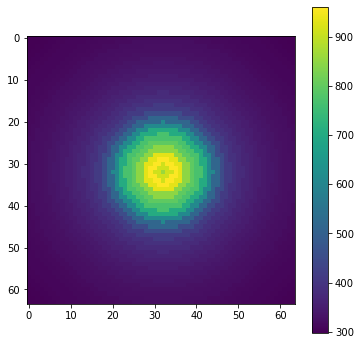

In [65]:
print("sigma noise min =", jnp.min(sigma_noise))
print("sigma noise max =", jnp.max(sigma_noise))
print("sigma noise mean =", jnp.mean(sigma_noise))

#sigma_noise = jnp.max(sigma_noise)*jnp.ones(sigma_noise.shape)
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([nx,nx]))); plt.colorbar()

In [232]:
imgs_f_m = imgs_f * mask2d.reshape(-1)

In [292]:
N_iter = 50100
eps = 1e-4
#eps = 1e-5
#eps = 1e-3
#eps = 1e-6
v0 = jnp.zeros([nx,nx,nx])* 1j
#alphas = [1.1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
#alphas = [1e-10, 1e-9, 1e-8]
alphas = [1e-8]
vcgs = []
fids = []
regs = []
losss = []
angles_cg = angles

In [293]:
N_alpha = len(alphas)
for alpha in alphas[:N_alpha]:
    t0 = time.time()
    print('alpha =', alpha)
    
    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
    grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)
    
    AA, Ab = get_cg_vol_ops(grad_loss_volume_sum, angles_cg, shifts, ctf_params, imgs_f_m, v0.shape, sigma_noise)
    vcg, _ = conjugate_gradient(AA, Ab, v0, N_iter, eps, verbose = True)
    
    fid = 2*fid_func_sum(vcg, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    reg = l2sq(vcg)/(nx*nx*nx)
    loss = loss_func_sum(vcg, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    
    vcgs.append(vcg)
    fids.append(fid)
    regs.append(reg)
    losss.append(loss)
    
    print("  fid =", fid)
    print("  reg =", reg)
    print("  loss =", loss)
    
    print("  Time =", time.time() - t0)
    
vcgs = jnp.array(vcgs)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

alpha = 1e-08
  cg iter 0 ||r|| = 0.0006530734857003482
  cg iter 50 ||r|| = 0.00036271066470436704
  cg iter 100 ||r|| = 0.0002448028276882383
  cg iter 150 ||r|| = 0.0001800771396830169
  cg iter 200 ||r|| = 0.00016214331007955086
  cg iter 250 ||r|| = 0.0001482164640101242
  cg iter 300 ||r|| = 0.00011204845827430622
  cg iter 350 ||r|| = 0.00015081597072255737
  cg iter 400 ||r|| = 0.00012536157464779112
  cg iter 450 ||r|| = 0.00011103298297622021
  cg iter 492 ||r|| = 9.988624749711148e-05
  fid = 11.919841723923643
  reg = 27817612.264153592
  loss = 10.410738824226396
  Time = 131.3923945426941


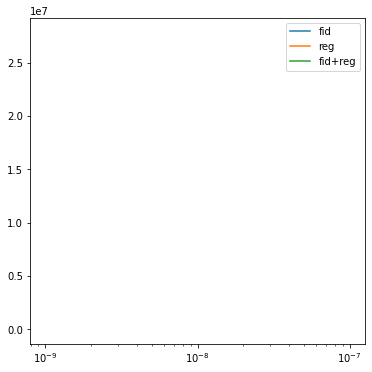

In [294]:
plt.semilogx(alphas, fids)
plt.semilogx(alphas, regs)
plt.semilogx(alphas, losss)
plt.legend(['fid', 'reg', 'fid+reg'])

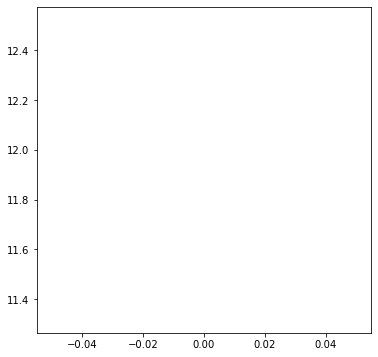

In [295]:
plt.plot(fids)

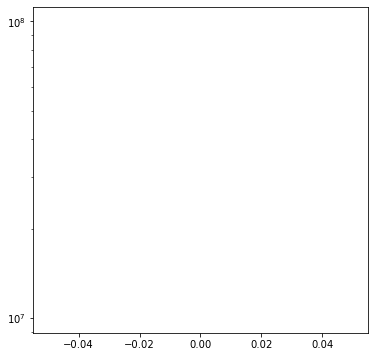

In [296]:
plt.semilogy(regs)

Pixel-wise loss for the best reconstruction:

In [297]:
mask.shape

(32, 32, 32)

In [50]:
def pixel_wise_fid_fun(v, slice_func_array, angles_, shifts, ctf_params, imgs, sigma):
    err = slice_func_array(v, angles, shifts, ctf_params) - imgs
    return jnp.mean(jnp.real(jnp.conj(err)*err), axis = 0)/(2*sigma**2)
    #return jnp.mean(jnp.real(jnp.conj(err)*err), axis = 0)/2

In [299]:
alphas[alpha_idx]

DeviceArray(1.e-08, dtype=float64)

In [300]:
sigma_noise1 = jnp.ones(sigma_noise.shape)

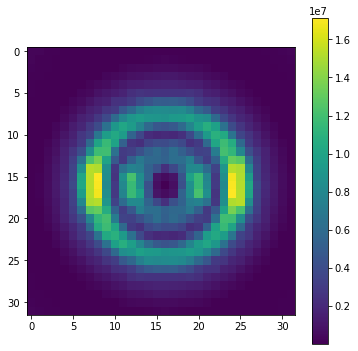

In [301]:
pw_fid = pixel_wise_fid_fun(vcgs[0], slice_func_array, angles, shifts, ctf_params, imgs_f_m, sigma_noise1)
plt.imshow(jnp.fft.fftshift(pw_fid.reshape([nx,nx]))); plt.colorbar()

Pixel-wise loss for the ZERO volume:

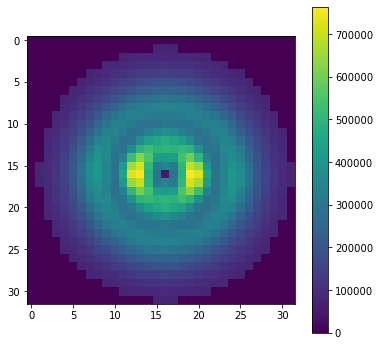

In [302]:
pw_fid0 = pixel_wise_fid_fun(jnp.zeros(v0.shape), slice_func_array, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise1)
plt.imshow(jnp.fft.fftshift(pw_fid0.reshape([nx,nx]))); plt.colorbar()

In [303]:
alpha_idx = jnp.argmin(fids)
print(alpha_idx)

0


In [304]:
#alpha_idx = 2

1e-08


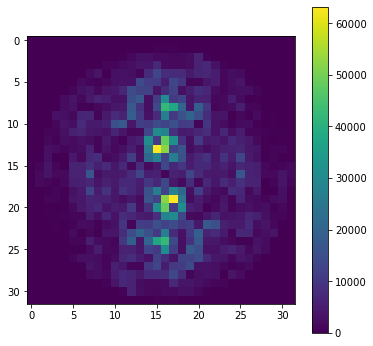

In [305]:
print(alphas[alpha_idx])
plt.imshow(jnp.abs(jnp.fft.fftshift(vcgs[alpha_idx][:,0,:]))); plt.colorbar()

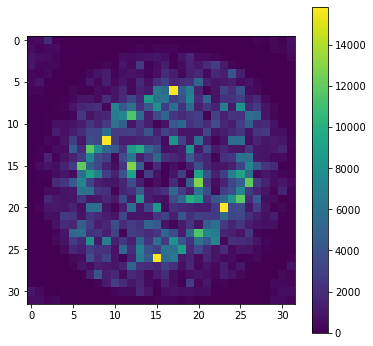

In [306]:
img_idx = 100
s0 = slice_func(vcgs[alpha_idx], angles_cg[img_idx], shifts[img_idx], ctf_params[img_idx])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

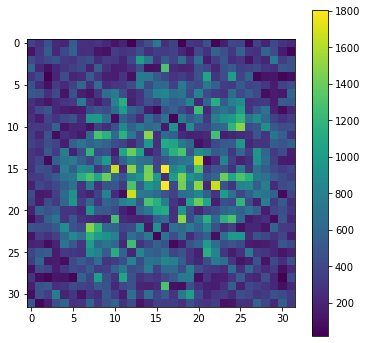

In [307]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[img_idx]).reshape(nx,nx))); plt.colorbar()

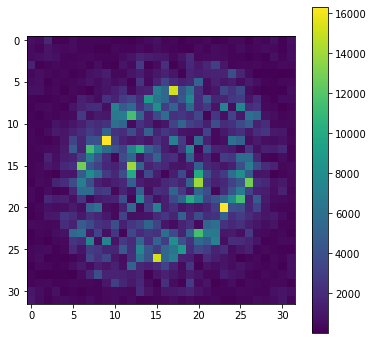

In [308]:
plt.imshow(jnp.fft.fftshift(jnp.abs(s0 - imgs_f[img_idx]).reshape(nx,nx))); plt.colorbar()

Text(0.5, 1.0, 'Reconstruction MIP')

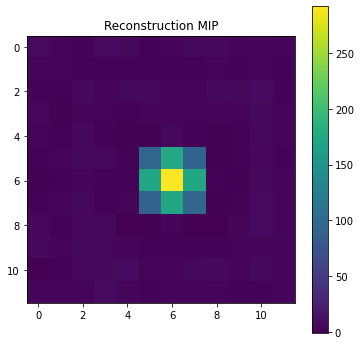

In [309]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction MIP')

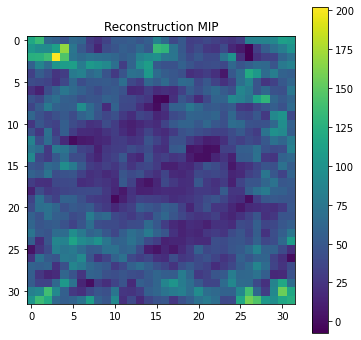

In [310]:
vcg_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcgs[alpha_idx])))
mip_z(vcg_r)
plt.colorbar()
plt.title('Reconstruction MIP')


In [ ]:
with mrcfile.new('../data/reconstruction_data_32_cg_alpha.mrc', overwrite=True) as mrc:
    mrc.set_data(vcg_r.astype(np.float32))

### All images are the same, with different scalings (corresponding to different orders of $\alpha$)

In [94]:
vcgs_s = vcgs[:,:,0,0]
vcgs_s.shape

(10, 32)

In [311]:
plt.plot(jnp.abs(vcgs_s[0]))
plt.plot(jnp.abs(vcgs_s[1])*9)
plt.plot(jnp.abs(vcgs_s[2])*90)
plt.plot(jnp.abs(vcgs_s[3])*900)
plt.plot(jnp.abs(vcgs_s[6])*9e5)
plt.plot(jnp.abs(vcgs_s[8])*9e7)
plt.plot(jnp.abs(vcgs_s[10])*9e8)

NameError: name 'vcgs_s' is not defined

### FSC, orientations, standard deviation for each voxel etc

In [312]:
vcg1 = vcgs[0]
vcg2 = vcgs[6]

In [313]:
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid)

In [315]:
points_v_tri = points_orientations_tri(angles, x_grid[1].astype(jnp.int64), number_of_batches = 1000)
#points_v_nn = points_orientations_nn(angles[:1000], x_grid[1])

Rotating coordinates
Finding point indices
Splitting in batches.
Adding up number of points from batches.


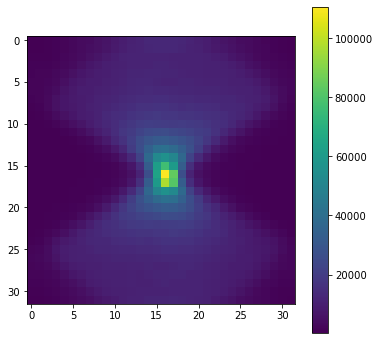

In [316]:
plt.imshow(jnp.fft.fftshift(points_v_tri[:,:,0])); plt.colorbar()

In [317]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid)

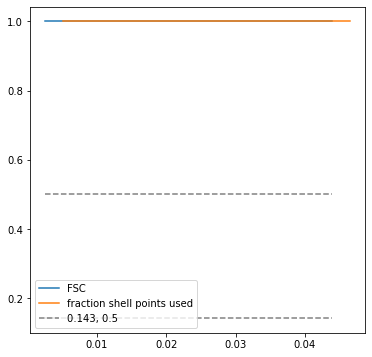

In [318]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

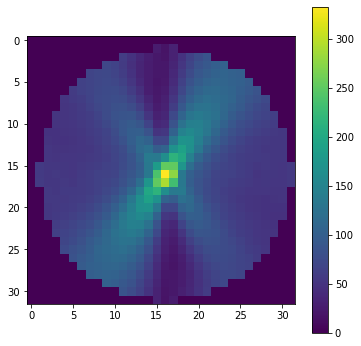

In [319]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[0,:,:]*mask[0,:,:]))))); plt.colorbar()

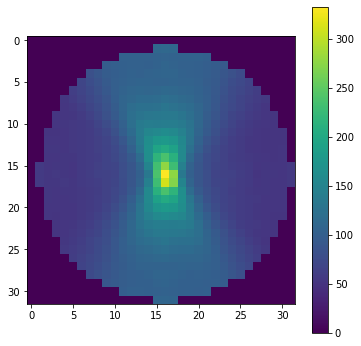

In [320]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,0,:]*mask[:,0,:]))))); plt.colorbar()

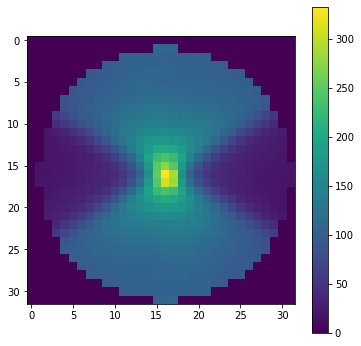

In [321]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,:,0]*mask[:,:,0]))))); plt.colorbar()

In [322]:
vones = jnp.ones(vcg1.shape)
omega = AA(vones)
omega = 1/omega

In [323]:
jnp.min(jnp.abs(omega))

DeviceArray(21356.67557362, dtype=float64)

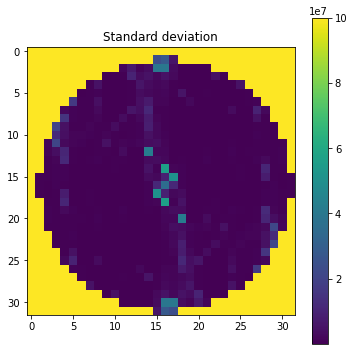

In [324]:
plt.title("Standard deviation")
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))); plt.colorbar()

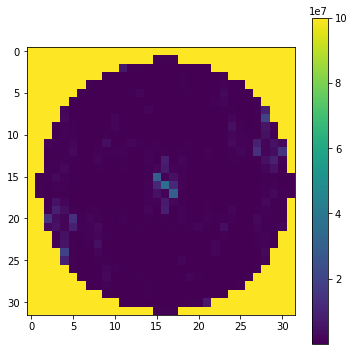

In [325]:
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[:,0,:]))); plt.colorbar()

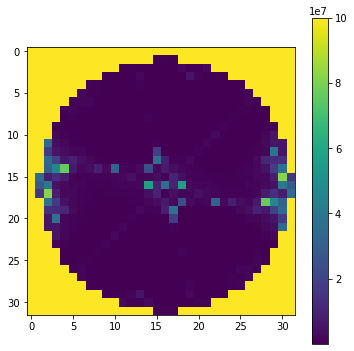

In [326]:
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[:,:,0]))); plt.colorbar()

### SGD

### Preconditioner

1e-06
1.000001
1e-06


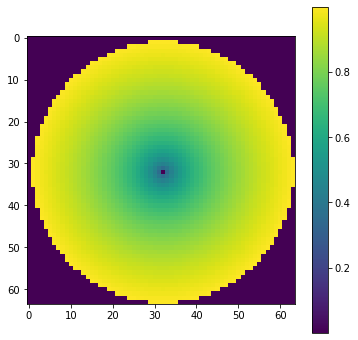

In [39]:
P = get_preconditioner(x_grid) * mask
#P = jnp.sqrt(P) /jnp.max(P) + 1e-6
#P = jnp.sqrt(P)
P = P**0.15
P = P /jnp.max(P)+ 1e-6
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

### Points/orientations preconditioner

In [40]:
P = points_v_tri +1
P = 1/P * mask + 1e-12
P = P/jnp.max(P) * mask
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

NameError: name 'points_v_tri' is not defined

### $\alpha$ tuning

In [42]:
mask2d = mask[:,:,0]
imgs_f_m = imgs_f * mask2d.reshape(-1)

In [43]:
N_epoch = 501000
batch_size = 300
#learning_rate = 100000
learning_rate = 10000 * 100
#learning_rate = 10000 # for "large" alpha

P = None

#eps = 3e-5
#eps = 1e-3
#eps = 1e-9
eps = 1e-8
v0 = jnp.zeros([nx,nx,nx])* 1j
#alphas = 1/100 * jnp.array([1e-9, 1e-8, 1e-7, 1.1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]) #, 1e0, 1e1, 1e2, 1e3]
#alphas = [1e-10, 1e-9, 1e-8, 1e-7]
alphas = [1e-9]

angles_gd = angles

In [66]:
vgds = []
fids = []
regs = []
losss = []

#N_alpha = 4
for alpha in alphas:
    t0 = time.time()
    print('alpha =', alpha)
    
    slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)

    grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

    sgd_grad_func = get_sgd_vol_ops(grad_loss_volume_sum, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
    
    vgd = sgd(sgd_grad_func, N, v0, learning_rate, N_epoch, batch_size, P, eps, verbose = True)
    
    fid = 2*fid_func_sum(vgd, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    reg = l2sq(vgd)/(nx*nx*nx)
    loss = loss_func_sum(vgd, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    
    vgds.append(vgd)
    fids.append(fid)
    regs.append(reg)
    losss.append(loss)
    
    print("  fid =", fid)
    print("  reg =", reg)
    print("  loss =", loss)
    
    print("  Time =", time.time() - t0)
    
vgds = jnp.array(vgds)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

alpha = 1e-09
  sgd epoch 0: mean gradient = 2.4416222429832636e-08
  sgd epoch 10: mean gradient = 2.229483749016131e-09
  fid = 0.7217584520857653
  reg = 7174.638502993368
  loss = 0.36110881447497845
  Time = 32.498202323913574


In [67]:
vgds = jnp.array(vgds)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

N_alpha= len(fids)

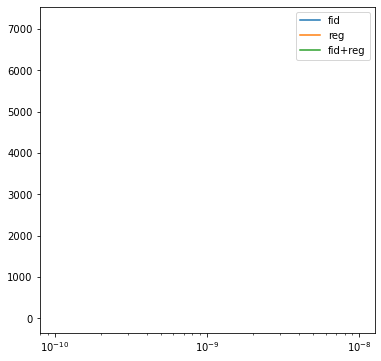

In [68]:
plt.semilogx(alphas[:N_alpha], fids)
plt.semilogx(alphas[:N_alpha], regs)
plt.semilogx(alphas[:N_alpha], losss)
plt.legend(['fid', 'reg', 'fid+reg'])

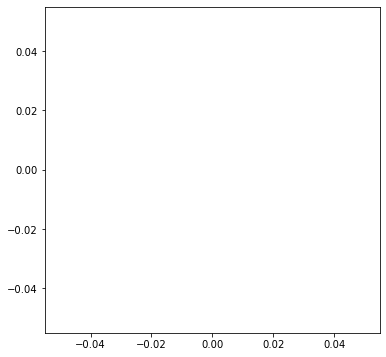

In [55]:
plt.plot(fids)

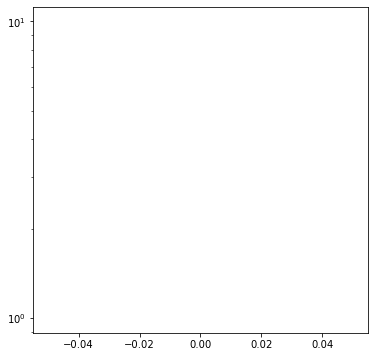

In [56]:
plt.semilogy(regs)

In [57]:
alphas[2]

DeviceArray(1.e-09, dtype=float64)

In [58]:
#alpha_idx= 3
#alpha_idx=5
#alpha_idx=0

0.6953319373768474


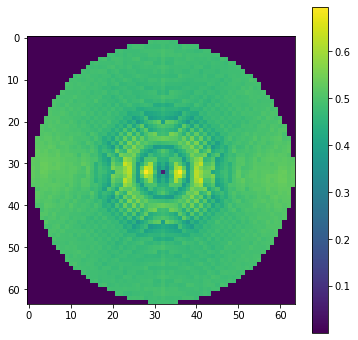

In [69]:
pw_fid = pixel_wise_fid_fun(vgds[alpha_idx], slice_func_array, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid.reshape([nx,nx]))); plt.colorbar()
print(jnp.max(pw_fid))

0.6953319373768474


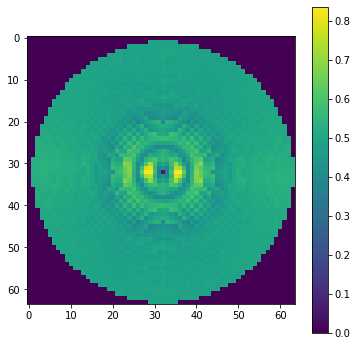

In [70]:
pw_fid0 = pixel_wise_fid_fun(jnp.zeros(vgd.shape), slice_func_array, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid0.reshape([nx,nx]))); plt.colorbar()
print(jnp.max(pw_fid))

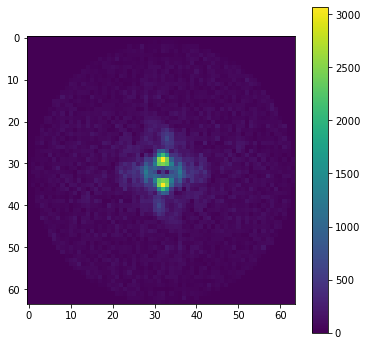

In [71]:
plt.imshow(jnp.fft.fftshift(jnp.abs(vgds[alpha_idx,:,0,:]))); plt.colorbar()

In [72]:
#plt.imshow(jnp.fft.fftshift(jnp.abs(v_rec[:,0,:]))); plt.colorbar()

In [344]:
#err = vgds[1] - v_rec
#plt.imshow(jnp.fft.fftshift((jnp.abs(err[:,0,:]))*mask[:,0,:])); plt.colorbar()

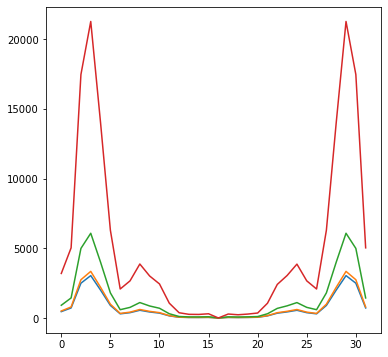

In [345]:
vgds_s = vgds[:,:,0,0]
vgds_s.shape

plt.plot(jnp.abs(vgds_s[0]))
plt.plot(jnp.abs(vgds_s[1])*1.1)
plt.plot(jnp.abs(vgds_s[2])*2)
plt.plot(jnp.abs(vgds_s[3])*7)


Text(0.5, 1.0, 'Reconstruction MIP')

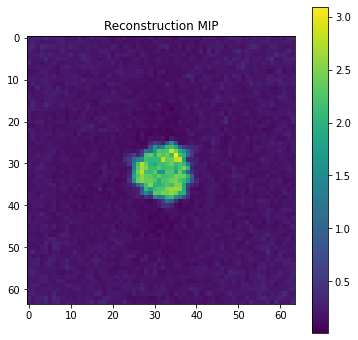

In [73]:
vr_sgd = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vgds[alpha_idx])))
mip_z(vr_sgd)
plt.colorbar()
plt.title('Reconstruction MIP')

In [74]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

NameError: name 'v_rec' is not defined

In [76]:
with mrcfile.new('../data/reconstruction_data_32_sgd_alpha.mrc', overwrite=True) as mrc:
    mrc.set_data(vr_sgd.astype(np.float32))

In [77]:
idx = 100

In [78]:
slicegd = slice_func(vgds[alpha_idx], angles_gd[idx], shifts[idx], ctf_params[idx])
#slicerec = slice_func(v_rec, angles_gd[idx], shifts[idx], ctf_params[idx])

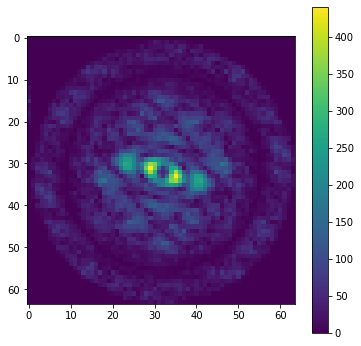

In [81]:
plt.imshow(jnp.abs(jnp.fft.fftshift(slicegd.reshape([nx,nx])))); plt.colorbar()

In [ ]:
#plt.imshow(jnp.abs(jnp.fft.fftshift(slicerec.reshape([32,32])))); plt.colorbar()

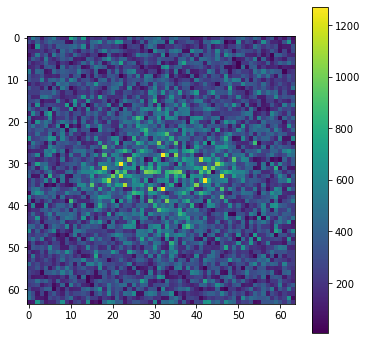

In [82]:
plt.imshow(jnp.abs(jnp.fft.fftshift(imgs_f[idx].reshape([nx,nx])))); plt.colorbar()